In [2]:
%matplotlib inline

import ROOT
from ROOT import TCanvas, TH1F, TLegend, TGraph
from ROOTDefs import get_signal_and_background_files
from LayersDefs import get_signal_and_background_frames,  predict_nn_on_all_frame, calculate_derived_et_columns, roc_curve, \
    background_eff_at_target_signal_eff, roc_cuts
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

#random.seed(7)
#np.random.seed(7)

Welcome to JupyROOT 6.18/00


In [3]:
signal_frame, background_frame = get_signal_and_background_frames()

In [4]:
tsig, fsig, tback, fback = get_signal_and_background_files('/eos/user/n/nicholas/SWAN_projects/NewTauSamples/dataFiles/ztt_Output_formatted.root', 
                                                           '/eos/user/n/nicholas/SWAN_projects/NewTauSamples/dataFiles/output_MB80_formatted.root')
tback.set_layer_dim(1, 13, 3)
tback.set_layer_dim(2, 13, 3)
tback.set_seed_region(4, 8, 1, 1)
new_adj_dict = {4: -1, 5: 0, 6: 0, 7: 0, 8: 1}
tback.set_adjacent_eta_cells(new_adj_dict)
tback.set_fcore_def([[3, 2], [13, 3]])

print(tsig.entries)

4078


In [9]:
#full_background_frame = background_frame.sample(n=len(background_frame))

# Sample from background frame so there are the same number of signal and background events
background_frame = background_frame.sample(n=len(signal_frame))

# Create new columns combining base columns
calculate_derived_et_columns(signal_frame, background_frame)

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L0Et', 'L1Et'],
                             output_column_name='L0+L1Et')
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L2Et', 'L3Et'],
                             output_column_name='L2+L3Et')

In [11]:
# Calculate 3 Et with minimum weights
#calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1.3, 8.4], column_names=['L0+L1Et', 'L2+L3Et', 'HadEt'],
#                             output_column_name='3EtWeighted')
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1.6, 1.4], column_names=['L0+L1Et', 'L2+L3Et', 'HadEt'],
                             output_column_name='3EtWeighted')

In [4]:
# Calculate 5 Et with minimum weights
#calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, .3, 3.6], column_names=['L0+L1Et', 'L2+L3Et', 'HadEt'],
#                             output_column_name='5EtWeighted')

# Break frames into one whose events have zero hadronic energy and one whose events have nonzero hadronic energy
no_had_sig = signal_frame[signal_frame['HadEt'] == 0].copy()
no_had_back = background_frame[background_frame['HadEt'] == 0].copy()

some_had_sig = signal_frame[signal_frame['HadEt'] != 0].copy()
some_had_back = background_frame[background_frame['HadEt'] != 0].copy()

# Calculate derived weighted Et column with minimum weight applied
calculate_derived_et_columns(no_had_sig, no_had_back, layer_weights=[1, 1.3], column_names=['L0+L1Et', 'L2+L3Et'], output_column_name='NoHadWeighted')

In [5]:
# Combine signal and background
all_frame = pd.concat([signal_frame, background_frame])

In [6]:
predicted_signal_frame, predicted_background_frame, _ = predict_nn_on_all_frame(all_frame, ['L0Et', 'L1Et', 'L2Et', 'L3Et', 'HadEt'], ['IsSignal'])

W1010 15:30:50.300432 140290423146304 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1010 15:30:50.415765 140290423146304 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
99784/99784 [==============================] - 8s 81us/sample - loss: 0.2267 - acc: 0.9227
Epoch 2/30
99784/99784 [==============================] - 8s 76us/sample - loss: 0.2234 - acc: 0.9238
Epoch 3/30
99784/99784 [==============================] - 8s 76us/sample - loss: 0.2225 - acc: 0.9235
Epoch 4/30
99784/99784 [==============================] - 8s 77us/sample - loss: 0.2241 - acc: 0.9244
Epoch 5/30
99784/99784 [==============================] - 8s 76us/sample - loss: 0.2227 - acc: 0.9236
Epoch 6/30
99784/99784 [==============================] - 7s 72us/sample - loss: 0.2235 - acc: 0.9234
Epoch 7/30
99784/99784 [==============================] - 7s 71us/sample - loss: 0.2228 - acc: 0.9237
Epoch 8/30
99784/99784 [==============================] - 6s 64us/sample - loss: 0.2223 - acc: 0.9239
Epoch 9/30
99784/99784 [==============================] - 6s 65us/sample - loss: 0.2240 - acc: 0.9234
Epoch 10/30
99784/99784 [==============================] - 6s 64us/sample - loss: 

2019-10-10 15:30:50.753080: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-10-10 15:30:50.770590: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400025000 Hz
2019-10-10 15:30:50.771805: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9d148f0 executing computations on platform Host. Devices:
2019-10-10 15:30:50.771837: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-10-10 15:30:50.819112: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

In [7]:
twohid_pred_sig, twohid_pred_back, twohid_model = predict_nn_on_all_frame(all_frame, ['L0Et', 'L1Et', 'L2Et', 'L3Et', 'HadEt'], ['IsSignal'], epochs=10, hidden_layers=2, hidden_nodes=8, lr=0.1)

print(twohid_model.summary())

Epoch 1/10
99784/99784 [==============================] - 10s 98us/sample - loss: 0.2065 - acc: 0.9242
Epoch 2/10
99784/99784 [==============================] - 9s 88us/sample - loss: 0.2025 - acc: 0.9266
Epoch 3/10
99784/99784 [==============================] - 8s 82us/sample - loss: 0.2024 - acc: 0.9268
Epoch 4/10
99784/99784 [==============================] - 9s 88us/sample - loss: 0.2029 - acc: 0.9269
Epoch 5/10
99784/99784 [==============================] - 7s 73us/sample - loss: 0.2021 - acc: 0.9270
Epoch 6/10
99784/99784 [==============================] - 8s 80us/sample - loss: 0.2063 - acc: 0.9253
Epoch 7/10
99784/99784 [==============================] - 8s 79us/sample - loss: 0.2053 - acc: 0.9262
Epoch 8/10
99784/99784 [==============================] - 8s 80us/sample - loss: 0.2042 - acc: 0.9269
Epoch 9/10
99784/99784 [==============================] - 7s 73us/sample - loss: 0.2027 - acc: 0.9272
Epoch 10/10
24946/24946 [==============================] - 1s 35us/sample - loss:

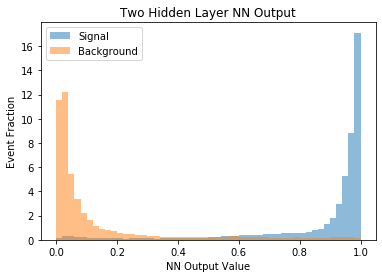

In [9]:
plt.hist(twohid_pred_sig['NNOutputValue'].values, 50, alpha=0.5, density=True, range=[0, 1], label='Signal')
plt.hist(twohid_pred_back['NNOutputValue'].values, 50, alpha=0.5, density=True, range=[0, 1], label='Background')
plt.title('Two Hidden Layer NN Output')
plt.xlabel('NN Output Value')
plt.ylabel('Event Fraction')
plt.legend(loc='upper left')
#plt.show()
plt.savefig('./plots/trainingUpdate/NNOutput.pdf')

In [10]:
print(len(twohid_pred_sig[twohid_pred_sig['NNOutputValue'] > 0.57]) / len(twohid_pred_sig))
print(len(twohid_pred_back[twohid_pred_back['NNOutputValue'] > 0.57]) / len(twohid_pred_back))


0.0
0.0


In [ ]:
# Apply cuts on weighted Et column, returning event counts instead of efficiencies
sig_had_cuts, back_had_cuts = roc_cuts(no_had_sig[['NoHadWeighted']], no_had_back[['NoHadWeighted']], netcuts=500, return_efficiencies=False)
sig_had_noweight, back_had_noweight = roc_cuts(no_had_sig[['TotalEt']], no_had_back[['TotalEt']], netcuts=500, return_efficiencies=False)

# Add back in some had events to get total event counts after cutting on only no had
sig_all_cuts = [i + len(some_had_sig) for i in sig_had_cuts]
back_all_cuts = [i + len(some_had_back) for i in back_had_cuts]

sig_all_noweight = [i + len(some_had_sig) for i in sig_had_noweight]
back_all_noweight = [i + len(some_had_back) for i in back_had_noweight]

# Divide by total number of events to get overall efficiencies
sig_all_eff = np.array([i / len(signal_frame) for i in sig_all_cuts])
back_all_eff = np.array([i / len(background_frame) for i in back_all_cuts])

sig_all_noweight_eff = np.array([i / len(signal_frame) for i in sig_all_noweight])
back_all_noweight_eff = np.array([i / len(background_frame) for i in back_all_noweight])

In [12]:
# Create ROC curves by cutting on total Et and also cutting on trained network classifier value
gr0 = roc_curve(background_frame[['TotalEt']], signal_frame[['TotalEt']], 1000)
gr1 = roc_curve(twohid_pred_back[['NNOutputValue']], twohid_pred_sig[['NNOutputValue']], 1000)
gr2 = roc_curve(background_frame[['3EtWeighted']], signal_frame[['3EtWeighted']], 1000)
gr3 = roc_curve(predicted_background_frame[['NNOutputValue']], predicted_signal_frame[['NNOutputValue']], 1000)

In [13]:
#gr4 = TGraph(len(sig_all_eff), back_all_eff, sig_all_eff)
#gr5 = TGraph(len(sig_all_noweight_eff), back_all_noweight_eff, sig_all_noweight_eff)
#c1.Close()
c1 = TCanvas("c1", "Graph Draw Options", 200, 10, 600, 400)

%jsroot on
gr0.Draw()
gr0.SetTitle('New Samples ROC Curves')
gr0.GetXaxis().SetTitle('Background Efficiency')
gr0.GetYaxis().SetTitle('Signal Efficiency')
gr0.SetMaximum(1)
gr0.SetMinimum(0.8)
gr0.GetXaxis().SetRangeUser(0, 0.2)
gr1.Draw('same')
gr1.SetLineColor(4)
gr2.Draw('same')
gr2.SetLineColor(8)
gr3.Draw('same')
gr3.SetLineColor(2)
#gr4.Draw('same')
#gr4.SetLineColor(6)
#gr5.Draw('same')
#gr5.SetLineColor(36)

leg = TLegend(0.4, 0.1, 0.9, 0.4)
leg.SetHeader('Layer Configuration')
leg.AddEntry(gr0, 'No training')
leg.AddEntry(gr3, 'Network Trained - No Hidden Layers')
leg.AddEntry(gr1, 'Network Trained - Two Hidden Layers')
leg.AddEntry(gr2, 'Manually Trained to 90% - L0+L1, L2+L3, Had Layers')

#leg.AddEntry(gr4, 'Manually Trained to 90%, Zero Had - L0+L1, L2+L3 Layers')
#leg.AddEntry(gr5, 'No training - Zero Had')
leg.SetTextSize(0.3)
leg.Draw()
c1.Update()
c1.Draw()
#c1.Print('./plots/NewTrainedROCCurvesWide.pdf')